# UTS - Klasifikasi: End-to-End Pipeline


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Load Data


In [6]:
df = pd.read_csv(r"KlasifikasiUTS.csv")
df.drop_duplicates(inplace=True)


## 2. Sampling

In [7]:
sampled_df = df.sample(n=50000, random_state=42)
X = sampled_df.drop("Class", axis=1)
y = sampled_df["Class"]

## 3. Feature Selection: Variance & Correlation


In [8]:
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X)
selected_cols = X.columns[selector.get_support()]
corr_matrix = pd.DataFrame(X_var, columns=selected_cols).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
X_selected = pd.DataFrame(X_var, columns=selected_cols).drop(columns=to_drop)

## 4. Normalisasi

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)


## 5. Train-Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


## 6. Model Initialization


In [11]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(probability=True)
}

results = {}

## 7. Training, Evaluation, & ROC Curve

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:30:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


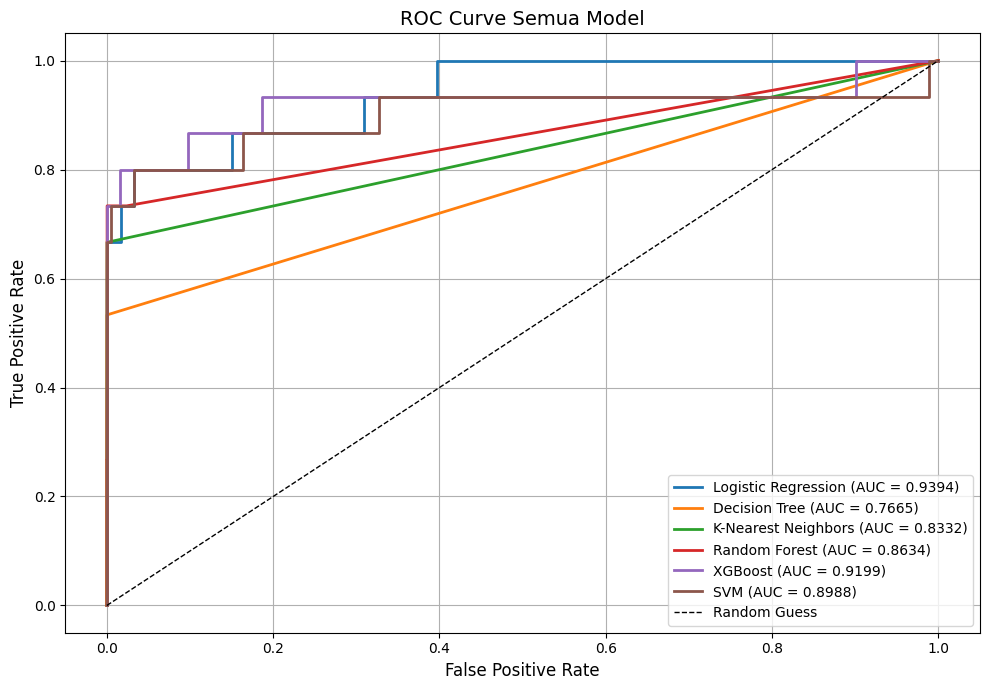

In [19]:

plt.figure(figsize=(10, 7))  # Lebih besar dan proporsional

for name, model in models.items():
    model.fit(X_train, y_train)

    # Cek metode proba atau decision function
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
    else:
        print(f"{name} skipped (no proba/decision_function)")
        continue

    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    # Plot ROC dengan label yang JELAS
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.4f})", linewidth=2)

# Tambahkan garis baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=1)

# Format visualisasi
plt.title("ROC Curve Semua Model", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Model Terbaik

In [17]:
best_model = max(results, key=results.get)
print("\nModel terbaik berdasarkan AUC:", best_model)


Model terbaik berdasarkan AUC: Logistic Regression
